[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed


Mean Squared Error: 3.4627488843654737
MAPE: 1.3404133880736715%
R² Score: 0.9985540499925617


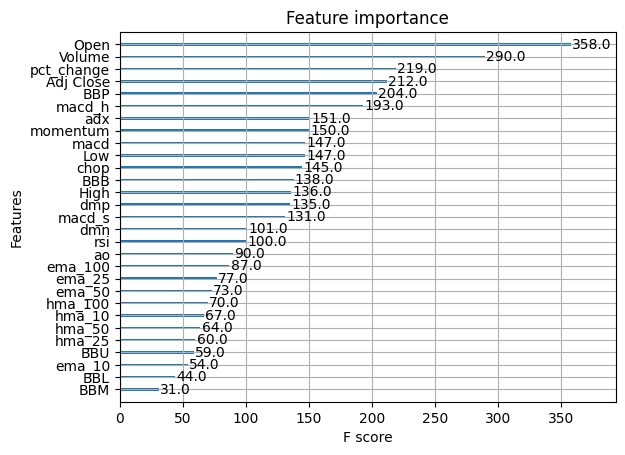


Predicting for WMB...

Predicting for KMI...

Predicting for OKE...

Predicting for OXY...

Predicting for CVX...

Predicting for XOM...

Predicting for PSX...

Predicting for EOG...

Predicting for FANG...

Predicting for SLB...


In [4]:
import pandas as pd
import numpy as np
import yfinance as yf
import pandas_ta as ta
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, r2_score
import xgboost as xgb
import matplotlib.pyplot as plt

# Preprocessing and feature extraction
def preprocess(stock_symbols, start, end):
    strat = ta.Strategy(
        name='Best Strategy Ever',
        ta=[
            {'kind':'ema', 'length':10, 'col_names':'ema_10'},
            {'kind':'ema', 'length':25, 'col_names':'ema_25'},
            {'kind':'ema', 'length':50, 'col_names':'ema_50'},
            {'kind':'ema', 'length':100, 'col_names':'ema_100'},
            {'kind':'hma', 'length':10, 'col_names':'hma_10'},
            {'kind':'hma', 'length':25, 'col_names':'hma_25'},
            {'kind':'hma', 'length':50, 'col_names':'hma_50'},
            {'kind':'hma', 'length':100, 'col_names':'hma_100'},
            {'kind':'macd', 'col_names':('macd', 'macd_h', 'macd_s')},
            {'kind':'rsi', 'col_names':'rsi'},
            {'kind':'mom', 'col_names':'momentum'},
            {'kind':'bbands', 'std':1, 'col_names':('BBL', 'BBM', 'BBU', 'BBB', 'BBP')},
            {'kind':'ao', 'col_names':'ao'},
            {'kind':'adx', 'col_names':('adx', 'dmp', 'dmn')},
            {'kind':'chop', 'col_names':'chop'},
        ]
    )
    stock_data = []
    for symbol in stock_symbols:
        data = yf.download(symbol, start=start, end=end).reset_index()
        data.ta.strategy(strat)
        data['pct_change'] = data['Close'].pct_change()
        data['target'] = data['Close'].shift(-1)  # Predict next day's price
        data['Symbol'] = symbol  # Add a column for stock symbol
        stock_data.append(data.dropna())
    return pd.concat(stock_data, ignore_index=True)

# Predict for the next N days
def predict_next_days_for_stock(model, stock_data, stock_features, days=10):
    latest_data = stock_data.tail(days).copy()
    latest_features = stock_features.tail(days)
    predictions = model.predict(latest_features)
    return predictions

# Main workflow
if __name__ == "__main__":
    # Define inputs
    start_date = "2024-01-01"
    end_date = "2025-01-01"
    #XLE-22
    energy_stocks_test = [
    "WMB",  # The Williams Companies Inc
    "KMI",  # Kinder Morgan Inc
    "OKE",  # ONEOK Inc
    "OXY",  # Occidental Petroleum Corp
    "CVX",  # Chevron Corp
    "XOM",  # Exxon Mobil Corp
    "PSX",  # Phillips 66
    "EOG",  # EOG Resources Inc
    "FANG", # Diamondback Energy Inc
    "SLB"   # Schlumberger NV
    ]
    # Preprocess data
    data = preprocess(energy_stocks_test, start_date, end_date)

    # Prepare features and target
    features = data.drop(columns=['Date', 'Close', 'target', 'Symbol'])
    target = data['target']

    # Train-test split
    X_train, X_test, y_train, y_test = train_test_split(features, target, test_size=0.2, random_state=42)

    # Train XGBoost model
    xg_reg = xgb.XGBRegressor(objective='reg:squarederror', n_estimators=100, max_depth=6, learning_rate=0.1)
    xg_reg.fit(X_train, y_train)

    # Make predictions
    predictions = xg_reg.predict(X_test)

    # Evaluate the model
    mse = mean_squared_error(y_test, predictions)
    mape = np.mean(np.abs((y_test - predictions) / y_test)) * 100
    r2 = r2_score(y_test, predictions)

    print(f"Mean Squared Error: {mse}")
    print(f"MAPE: {mape}%")
    print(f"R² Score: {r2}")

    # Plot feature importance
    xgb.plot_importance(xg_reg)
    plt.show()

    # Predict next 10 days for all stocks
    all_predictions = {}
    for stock in energy_stocks_test:
        print(f"\nPredicting for {stock}...")
        
        # Filter data for the specific stock
        stock_data = data[data['Symbol'] == stock]
        stock_features = stock_data.drop(columns=['Date', 'Close', 'target', 'Symbol'])

        # Predict for the next 10 days
        predictions = predict_next_days_for_stock(xg_reg, stock_data, stock_features, days=10)
        all_predictions[stock] = predictions

In [5]:
# Predict next 10 days for all stocks and compare with actual prices
all_predictions = {}
all_actuals = {}
all_differences = {}
average_percentage_differences = {}

for stock in energy_stocks_test:
    print(f"\nPredicting for {stock}...\n")
    
    # Filter data for the specific stock
    stock_data = data[data['Symbol'] == stock]
    stock_features = stock_data.drop(columns=['Date', 'Close', 'target', 'Symbol'])  # Exclude 'Symbol' from features

    # Predict for the next 10 days
    predictions = predict_next_days_for_stock(xg_reg, stock_data, stock_features, days=10)
    all_predictions[stock] = predictions
    
    # Fetch actual future prices (next 10 days) for comparison
    future_data = yf.download(stock, start=end_date, end="2025-02-10")  # Assuming the next 10 days are after the end_date
    
    # Ensure that we have enough data
    if len(future_data) >= 10:
        actual_prices = future_data['Close'].head(10).values
        all_actuals[stock] = actual_prices
    else:
        print(f"Warning: Not enough data for {stock}. Skipping comparison.")
        all_actuals[stock] = np.array([])  # Set an empty array if there is not enough data

# Calculate the average percentage difference for each stock
for stock in energy_stocks_test:
    print(f"\n{stock} Predictions vs Actuals for the Next 10 Days:")
    predictions = all_predictions[stock]
    actuals = all_actuals[stock]
    
    # Check if actuals are empty
    if actuals.size > 0:
        differences = predictions - actuals
        percentage_differences = (differences / actuals) * 100

        for day in range(10):
            print(f"Day {day + 1}: Predicted Price = {predictions[day]:.2f}, Actual Price = {actuals[day]:.2f}, "
                  f"Difference = {differences[day]:.2f}, Percentage Difference = {percentage_differences[day]:.2f}%")
        
        # Calculate the average percentage difference
        avg_percentage_diff = np.mean(np.abs(percentage_differences))
        average_percentage_differences[stock] = avg_percentage_diff
        print(f"Average Percentage Difference for {stock}: {avg_percentage_diff:.2f}%")
    else:
        print("No actual data available for comparison.")

# Print the average percentage difference for all stocks
print("\nAverage Percentage Difference for Each Stock:")
for stock, avg_diff in average_percentage_differences.items():
    print(f"{stock}: {avg_diff:.2f}%")


Predicting for WMB...



[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed



Predicting for KMI...


Predicting for OKE...



[*********************100%***********************]  1 of 1 completed



Predicting for OXY...



[*********************100%***********************]  1 of 1 completed



Predicting for CVX...



[*********************100%***********************]  1 of 1 completed



Predicting for XOM...



[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed



Predicting for PSX...


Predicting for EOG...



[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed



Predicting for FANG...


Predicting for SLB...



[*********************100%***********************]  1 of 1 completed


WMB Predictions vs Actuals for the Next 10 Days:
Day 1: Predicted Price = 53.69, Actual Price = 55.88, Difference = -2.19, Percentage Difference = -3.92%
Day 2: Predicted Price = 52.83, Actual Price = 56.60, Difference = -3.77, Percentage Difference = -6.65%
Day 3: Predicted Price = 52.28, Actual Price = 55.81, Difference = -3.53, Percentage Difference = -6.33%
Day 4: Predicted Price = 53.43, Actual Price = 55.55, Difference = -2.12, Percentage Difference = -3.81%
Day 5: Predicted Price = 53.73, Actual Price = 56.39, Difference = -2.66, Percentage Difference = -4.71%
Day 6: Predicted Price = 54.21, Actual Price = 55.52, Difference = -1.31, Percentage Difference = -2.36%
Day 7: Predicted Price = 54.48, Actual Price = 56.03, Difference = -1.55, Percentage Difference = -2.77%
Day 8: Predicted Price = 53.74, Actual Price = 58.06, Difference = -4.32, Percentage Difference = -7.45%
Day 9: Predicted Price = 53.21, Actual Price = 58.01, Difference = -4.80, Percentage Difference = -8.27%
Day 1

In [6]:
# Print the average percentage difference for all stocks
print("\nAverage Percentage Difference for Each Stock:")
for stock, avg_diff in average_percentage_differences.items():
    print(f"{stock}: {avg_diff:.2f}%")


Average Percentage Difference for Each Stock:
WMB: 5.50%
KMI: 5.83%
OKE: 3.23%
OXY: 7.68%
CVX: 5.92%
XOM: 2.05%
PSX: 3.66%
EOG: 7.85%
FANG: 9.22%
SLB: 5.09%
